# Plot 3C waveforms of a subarray in a time window

In [54]:
# Import modules
from obspy import read, UTCDateTime, Stream
from matplotlib.pyplot import figure, subplots
from matplotlib.patches import Rectangle
import matplotlib.dates as mdates
from numpy import abs, mean, amin, amax
from pandas import read_csv, Timestamp, Timedelta, to_datetime
from os.path import join

from utils_basic import ROOTDIR, INNER_STATIONS, days_to_timestamps
from utils_preproc import preprocess_stream
from utils_sta_lta import read_associated_events

In [55]:
# Inputs
rootdir = ROOTDIR
starttime = Timestamp("2020-01-16T22:00:00")
dur = 120.0 # Duration in seconds
# plot_detect = False # Plot STA/LTA detections or not
# plot_assoc = False # Plot associated detections or not

freqmin = 10.0
freqmax = 450

scale = 7.5e-4 # Scale factor for plotting
size = 20 # Size of the dots for detections

linewidth = 0.25 

timewin = starttime.strftime("%Y-%m-%d-%H-00-00")

In [56]:
# Read the station list
inpath = join(rootdir, "stations.csv")
stadf = read_csv(inpath, index_col=0)
numst = len(stadf)

In [57]:
# Read the marker file
timestr = starttime.strftime("%Y-%m-%d-%H-%M-%S")
filename = f"markers_{timestr}_{dur:.0f}s.csv"
inpath = join(rootdir, timewin, filename)

mkdf = read_csv(inpath, index_col=0)
mkdf["time"] = to_datetime(mkdf["time"])

In [58]:
# Read and preprocess the data
starttime = UTCDateTime(starttime)

stream = Stream()
for station in stadf["name"]:
    try:
        pattern = join(rootdir, timewin, f"*{station}*.SAC")
        stream += read(pattern)
    except:
        print(f"Could not read Station {station}")
        continue

stream = preprocess_stream(stream, freqmin, freqmax)
stream.trim(starttime, starttime + dur)

Could not read Station A12


111 Trace(s) in Stream:

7F.A01..GH1 | 2020-01-16T22:00:00.000000Z - 2020-01-16T22:02:00.000007Z | 1000.0 Hz, 120001 samples
...
(109 other traces)
...
7F.B20..GHZ | 2020-01-16T22:00:00.000000Z - 2020-01-16T22:02:00.000007Z | 1000.0 Hz, 120001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

Could not plot A12


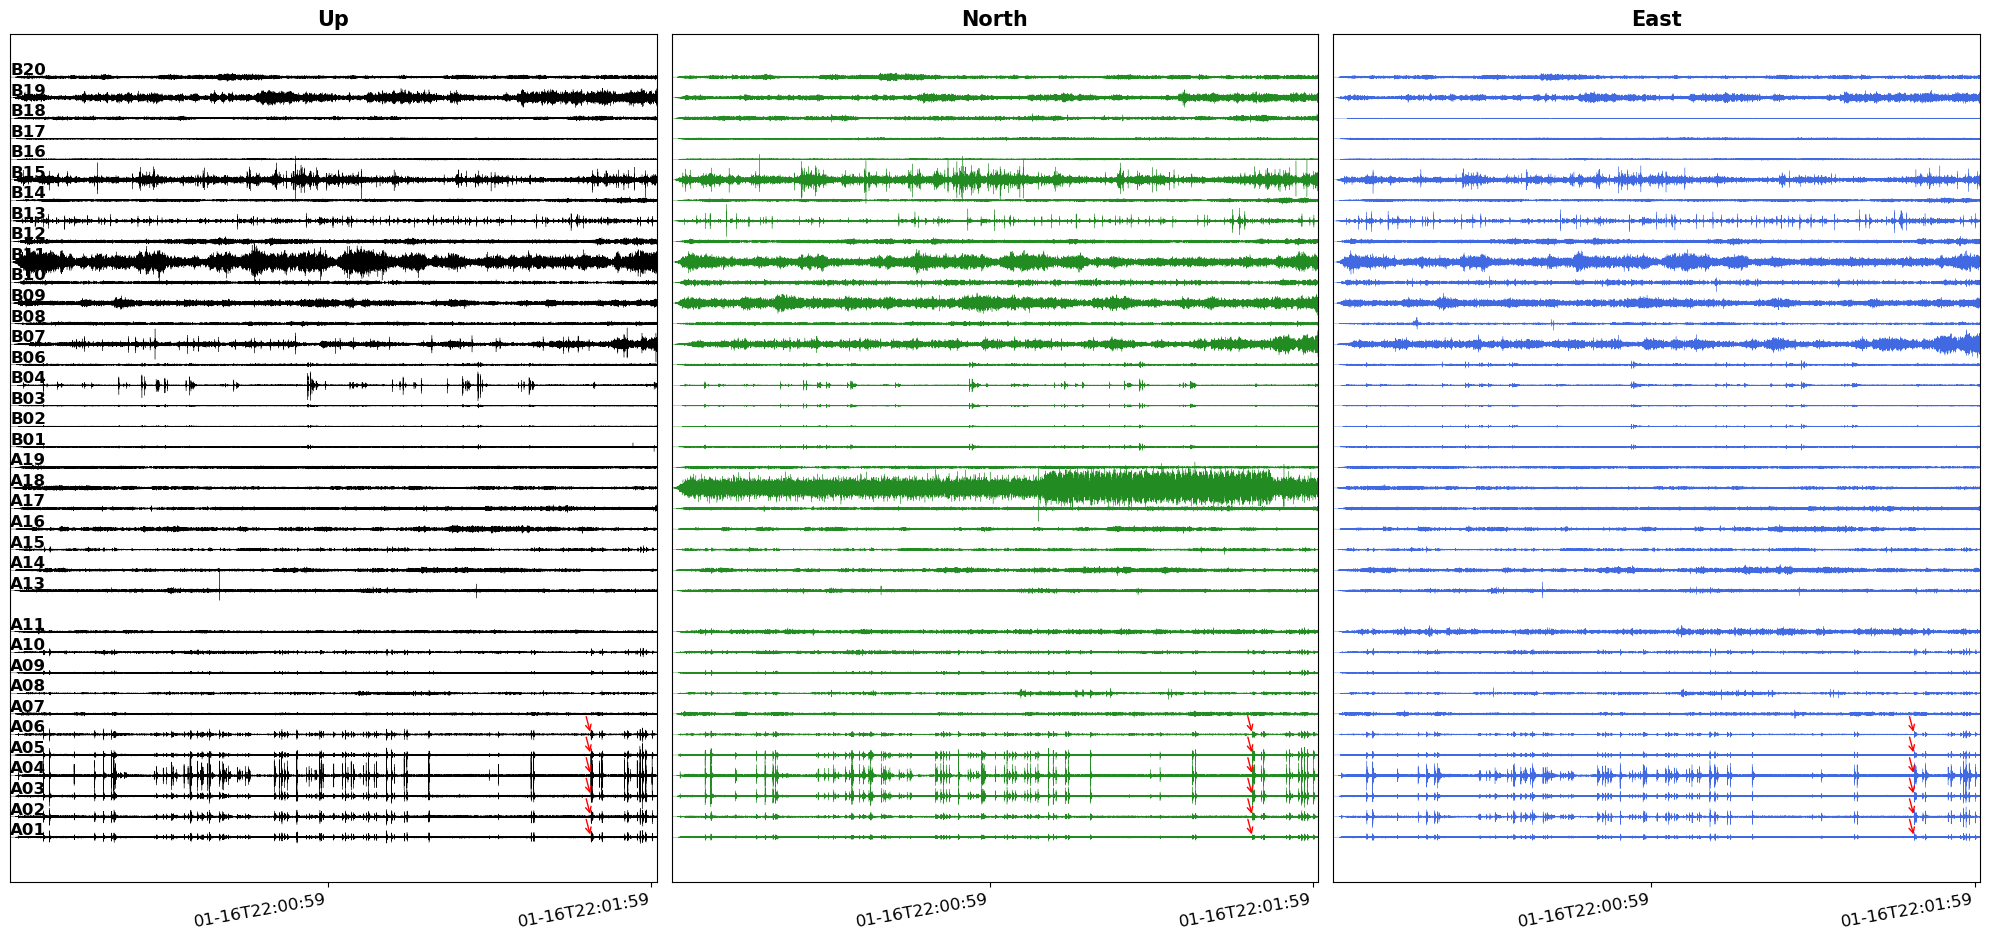

In [59]:
# Plotting
fig, axes = subplots(nrows=1, ncols=3, sharex=True, sharey=True, figsize=(20, 0.25*numst))

## Loop over the stations
for i, station in enumerate(stadf["name"]):

    ### Exract and plot the waveforms
    try:
        trace_z = stream.select(station=station, channel="*Z")[0]
        trace_1 = stream.select(station=station, channel="*1")[0]
        trace_2 = stream.select(station=station, channel="*2")[0]

        data_z = trace_z.data * scale + i
        data_1 = trace_1.data * scale + i
        data_2 = trace_2.data * scale + i
    except:
        print(f"Could not plot {station}")
        continue
    
    ### Convert the time axis to Pandas Timestamps
    timeax = trace_z.times("matplotlib")
    timeax = days_to_timestamps(timeax)

    axes[0].plot(timeax, data_z, color="black", linewidth=linewidth)
    axes[1].plot(timeax, data_1, color="forestgreen", linewidth=linewidth)
    axes[2].plot(timeax, data_2, color="royalblue", linewidth=linewidth)

    axes[0].annotate(station, xy=(timeax[0], i+0.1), xycoords="data", fontsize=12, fontweight="bold")

    ### Plot the markers
    if station in mkdf["station"].values:
        mktime = mkdf.loc[mkdf["station"] == station]["time"].values[0]
        axes[0].annotate('', xy=(mktime, i), xytext=(mktime-Timedelta(seconds=2.0), i+1), arrowprops=dict(arrowstyle='->', color='red'))
        axes[1].annotate('', xy=(mktime, i), xytext=(mktime-Timedelta(seconds=2.0), i+1), arrowprops=dict(arrowstyle='->', color='red'))
        axes[2].annotate('', xy=(mktime, i), xytext=(mktime-Timedelta(seconds=2.0), i+1), arrowprops=dict(arrowstyle='->', color='red'))

## Set the x-axis limits
axes[0].set_xlim([timeax[0], timeax[-1]])
axes[1].set_xlim([timeax[0], timeax[-1]])
axes[2].set_xlim([timeax[0], timeax[-1]])

## Format x-axis as date time
axes[0].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[1].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))
axes[2].xaxis.set_major_formatter(mdates.DateFormatter('%m-%dT%H:%M:%S'))

for label in axes[0].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[1].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

for label in axes[2].get_xticklabels():
    label.set_fontsize(12)
    label.set_verticalalignment('top')
    label.set_horizontalalignment('right')
    label.set_rotation(10)

# Set titles
axes[0].set_title("Up", fontsize=15, fontweight="bold")
axes[1].set_title("North", fontsize=15, fontweight="bold")
axes[2].set_title("East", fontsize=15, fontweight="bold")

# Set x label spacing to 60 seconds
axes[0].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[1].xaxis.set_major_locator(mdates.SecondLocator(interval=60))
axes[2].xaxis.set_major_locator(mdates.SecondLocator(interval=60))

# Turn off the y-axis labels and ticks
axes[0].set_yticks([])
axes[1].set_yticks([])
axes[2].set_yticks([])

axes[0].set_yticklabels([])
axes[1].set_yticklabels([])
axes[2].set_yticklabels([])

fig.tight_layout()
fig.patch.set_alpha(0.0)


In [60]:
## Save the figure
timestr = starttime.strftime("%Y-%m-%d-%H-%M-%S")
filename = f"sample_waveforms_whole_array_{timestr}_{dur}s.png"

outpath = join(rootdir, timewin, filename)
fig.savefig(outpath, dpi=300)
print(f"Saved {outpath}")

Saved /Volumes/OmanData/geophones_no_prefilt/data/2020-01-16-22-00-00/sample_waveforms_whole_array_2020-01-16-22-00-00_120.0s.png
